## Rede Neural para identificar dígitos em rabiscos

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#função transform que transforma os dados de imagem em tensores e depois os normaliza para ficar entre 0 e 1
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

#download do dataset MNIST:

#train True para o training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#train False para o test set
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#criando os dataloaders:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [6]:
print("Número de imagens de conjunto de treino:", len(train_set))
print("Número de imagens de conjunto de teste:", len(test_set))


Número de imagens de conjunto de treino: 60000
Número de imagens de conjunto de teste: 10000


In [7]:
print(f"Dimensões das imagens no dataset de treino: {train_loader.dataset[0][0].shape} px")

Dimensões das imagens no dataset de treino: torch.Size([1, 28, 28]) px


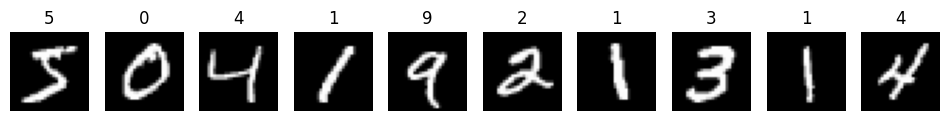

In [8]:
#ver as 10 primeiras imagens com suas anotações

fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for i in range(10):
    axes[i].imshow(train_loader.dataset[i][0].squeeze(), cmap='gray')
    axes[i].set_title(train_loader.dataset[i][1])
    axes[i].axis('off')
plt.show()

### Construindo a rede

In [9]:
class NeuralNetwork(nn.Module): #definindo o módulo da rede neural
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.input = nn.Linear(28*28, 128) #784 neurônios na input layer, output para 128 neuronios da próxima
        self.hidden = nn.Linear(128, 64)   #duas hidden layers, 128 e 64 neurônios, output de 10 neuronios da próxima
        self.output = nn.Linear(64, 10)   #output layer com 10 neuônios, um pra cada possível dígito

    def forward(self, x): 
        x = x.view(-1, 28*28) #tranformando o input x de um array bidimensional 28x28 para um vetor de 784 posições
        x = F.relu(self.input(x)) #ReLu para comunicar a ativação para a próxima camada
        x = F.relu(self.hidden(x)) #ReLu para comunicar a ativação para a próxima camada
        x = F.log_softmax(self.output(x), dim=1) #Softmax para transformar a ativação do neurônio em probabilidade do dígito inferido
        return x
    
model = NeuralNetwork()

### Treinamento

In [14]:
loss_function = nn.NLLLoss() #usando a Negative Log Likelihood Loss function (responde com um valor alto se algo está errado e um valor baixo se está tudo certo ( -log(softmax, que é a probabilidade de output) ) )

optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer Adam é uma implementação de backpropagation, lr é learning rate

epochs = 50
for epoch in range(epochs):
    for images, labels in train_loader:
        optimizer.zero_grad() #reseta os gradients(determinam como e quais pesos devem ser ajustados), cada vez que processamos um novo batch, começamos com zero gradients

        output = model(images) #faz predições 
        loss = loss_function(output, labels) #calcula loss 
        
        loss.backward() #calcula todos os gradients para todos os neurônios na rede baseado no loss calculado
        optimizer.step() #aplica os gradients calculados para ajustar os pesos

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0021
Epoch [2/50], Loss: 0.0002
Epoch [3/50], Loss: 0.0003
Epoch [4/50], Loss: 0.0016
Epoch [5/50], Loss: 0.0003
Epoch [6/50], Loss: 0.1888
Epoch [7/50], Loss: 0.0477
Epoch [8/50], Loss: 0.0096
Epoch [9/50], Loss: 0.0004
Epoch [10/50], Loss: 0.0011
Epoch [11/50], Loss: 0.0595
Epoch [12/50], Loss: 0.0004
Epoch [13/50], Loss: 0.0092
Epoch [14/50], Loss: 0.0909
Epoch [15/50], Loss: 0.0629
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0045
Epoch [18/50], Loss: 0.0003
Epoch [19/50], Loss: 0.0477
Epoch [20/50], Loss: 0.0862
Epoch [21/50], Loss: 0.0004
Epoch [22/50], Loss: 0.0001
Epoch [23/50], Loss: 0.0032
Epoch [24/50], Loss: 0.0016
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0003
Epoch [27/50], Loss: 0.0031
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0108
Epoch [30/50], Loss: 0.0022
Epoch [31/50], Loss: 0.0005
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0710
Epoch [34/50], Loss: 0.1021
Epoch [35/50], Loss: 0.0002
Epoch [36/50], Loss: 0.0001
E

### Testes

In [15]:
def view_classify(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

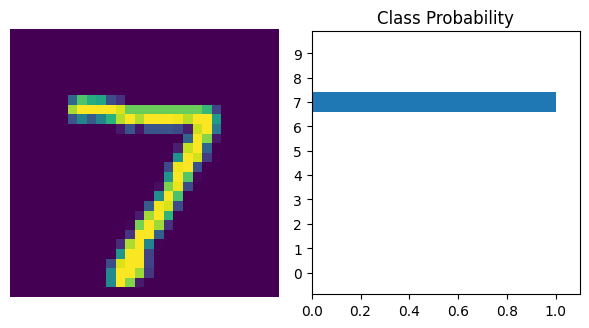

In [16]:
images, _ = next(iter(test_loader))

image = images[0]
with torch.no_grad(): #pytorch tende a acumular gradients durante o treinamento, então usamos no_grad() para desabilitar esse comportamento durante predições
    log_probabilities = model(image) #lembrar que os outputs do modelo são os logaritmos das probabilidades

probabilities = torch.exp(log_probabilities) #converte os logaritmos em probabilidades novamente, exponenciando

view_classify(image.view(1, 28, 28), probabilities)

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Acurácia da rede neural nas {total} imagens de teste: {100 * correct / total}%')

Acurácia da rede neural nas 10000 imagens de teste: 97.82%
